In [178]:
import function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
importlib.reload(function)
from function import calc_dist,calc_theta,rotate_point,match_points,calc_edge_list,plot_stars


In [179]:
def csv_to_human_test_data(filename):
    df=pd.read_csv(filename)

    names=df['name'].values
    x=df['x'].values
    y=df['y'].values
    p=df['p'].values
    position=np.column_stack((x,y))
    idx_Lsho=np.where(names=='L_shoulder')[0][0]
    idx_Rsho=np.where(names=='R_shoulder')[0][0]
    neck_position=(position[idx_Lsho]+position[idx_Rsho])/2

    idx_Lwai=np.where(names=='L_waist')[0][0]
    idx_Rwai=np.where(names=='R_waist')[0][0]
    stomach_position=(position[idx_Lwai]+position[idx_Rwai])/2

    new_name=np.array(['Neck','Stomach'])
    new_position=np.array([neck_position,stomach_position])
    names=np.concatenate((new_name,names))
    position=np.vstack((new_position,position))
    
    return names,position

In [180]:
class Local:
    def __init__(self,direction=None):
        self.direction=direction
        self.min_dist=None
        self.min_stars=None
        self.min_a_points=None
        self.edge_list=None
        self.near_dot=None
        self.star_data=None
        self.dotsize_x=None
        self.dotsize_y=None
        self.reshaped_position=None

    def __str__(self):
        return self.direction
   


In [181]:

class Search_min:
    def __init__(self,local_list=[]):
        self.local_list=local_list

    def add_local(self,local):
        self.local_list.append(local)
        
    def print_result(self,point_edge_list):
        min_dist=float('inf')
        min_local=None
        for local in self.local_list:
            if local.min_dist<min_dist:
                min_dist=local.min_dist
                min_local=local
        if min_local.direction=='north':
            print('north')
            plot_stars([north],point_edge_list)
        elif min_local.direction=='south':
            print('south')
            plot_stars([south],point_edge_list)
        elif min_local.direction=='equator' or min_local.direction=='ex_equator':
            print(min_local)
            plot_stars([equator,ex_equator],point_edge_list)
        else:
            print(error)
        



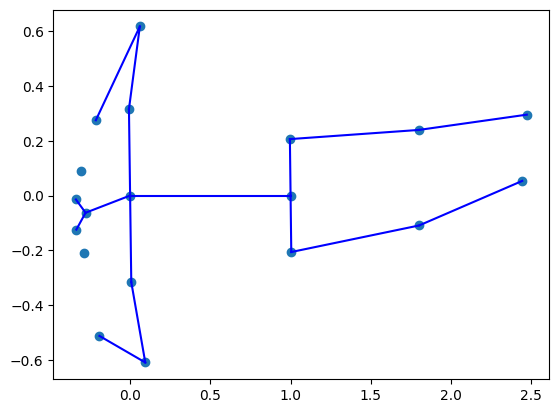

In [182]:
names,points=csv_to_human_test_data('../point_data/human_test/test_csv/person7.csv')
p=len(points)
points_size=p

point_edge_list=[(0,1),(0,2),(0,7),(0,8),(1,13),(1,14),(2,3),(2,4),(7,9),(8,10),(9,11),(10,12),(13,15),(14,16),(15,17),(16,18)]

for i in range(1,p):
    points[i]=points[i]-points[0]
points[0]=np.array([0,0])
norm=np.linalg.norm(points[1])
theta=calc_theta(points[1])
for i  in range(1,p):
    points[i]=rotate_point(points[i]/norm,(-1)*theta)

plt.scatter(points[:,0],points[:,1])
for edge in point_edge_list:
    p1=points[edge[0]]
    p2=points[edge[1]]
    plt.plot((p1[0],p2[0]),(p1[1],p2[1]),color='blue')

In [183]:
north=Local('north')
south=Local('south')
equator=Local('equator')
ex_equator=Local('ex_equator')

all_locals=Search_min([north,south,equator,ex_equator])


In [184]:
#データの読み込み、クラスの初期化
for direction in [north,south,equator,ex_equator]:
    star_data_url=f'./data/{direction.direction}/star_data.npy'
    near_dot_url=f'./data/{direction.direction}/near_dot.npy'
    reshaped_position_url=f'./data/{direction.direction}/reshaped_position.npy'
    direction.star_data=np.load(star_data_url)
    direction.near_dot=np.load(near_dot_url)
    direction.reshaped_position=np.load(reshaped_position_url)
    if direction==north or direction==south:
        direction.dotsize_x=200
        direction.dotsize_y=200
    elif direction==equator:
        direction.dotsize_x=400
        direction.dotsize_y=100
    else:
        direction.dotsize_x=200
        direction.dotsize_y=100
        


In [209]:
#edge_listの計算
for direction in [north,south,equator,ex_equator]:
    x,y=direction.star_data[:,0],direction.star_data[:,1]
    direction.edge_list=calc_edge_list(x,y,0,0.15)
    #print(direction.edge_list)



In [213]:
for direction in [north,south,equator,ex_equator]: 
    print(direction)
    star_data=direction.star_data  
    reshaped_position=direction.reshaped_position
    x,y,lum,HIPnum=star_data[:,0],star_data[:,1],star_data[:,2],star_data[:,3]
    a_x=reshaped_position[:,0]
    a_y=reshaped_position[:,1]
    size=7*np.exp(-1*(lum+2)*np.log(2))
    penalty_of_size=8*np.exp(-5*size*np.log(2)-1)
    direction.min_dist=float('inf')
    #print(len(a_x))
    for edge in direction.edge_list:
        node1,node2=edge
        star_1=reshaped_position[node1]
        star_2=reshaped_position[node2]
        norm=np.linalg.norm(star_2-star_1)
        theta=calc_theta(star_2-star_1)
        a_points=match_points(points,norm,theta,star_1)
        near_stars=[-1 for _ in range(points_size)]
        dist=0
        for i in range(points_size):
            a_point=a_points[i]
            a_point_x=int(round(a_point[0],0))
            a_point_y=int(round(a_point[1],0))
            #ここの処理は変えたほうがいいかも
            if a_point_x<0 or a_point_x>=direction.dotsize_x or a_point_y<0 or a_point_y>=direction.dotsize_y:
                break
            indice3=direction.near_dot[a_point_y][a_point_x]
            #print(indice3,len(a_x),len(a_y))
            nearest_star=np.array([a_x[indice3],a_y[indice3]]).reshape(-1)
            dist+=np.sum((a_point-nearest_star)**2)/(norm**(2))
            near_stars[i]=indice3
            if dist>direction.min_dist:
                break
            if i==points_size-1:
                shape_penalty_rate=0
                for j in range(points_size):
                    shape_penalty_rate+=penalty_of_size[near_stars[j]]
                    for k in range(j+1,points_size):
                        if near_stars[j]==near_stars[k]:
                            if (j,k) in direction.edge_list:
                                shape_penalty_rate+=0.5
                            else:
                                shape_penalty_rate+=1
                shape_penalty_rate+=norm/30
                dist=dist*(1+shape_penalty_rate)
                if dist>direction.min_dist:
                    break
                direction.min_dist=dist 
                direction.min_stars=near_stars
                direction.min_a_points=a_points
            if dist>direction.min_dist:
                break
    print(direction.min_dist)

    

    

    




north
36.400303630910756
south
20.217601564335272
equator
18.107869738411814
ex_equator
19.06249277041377


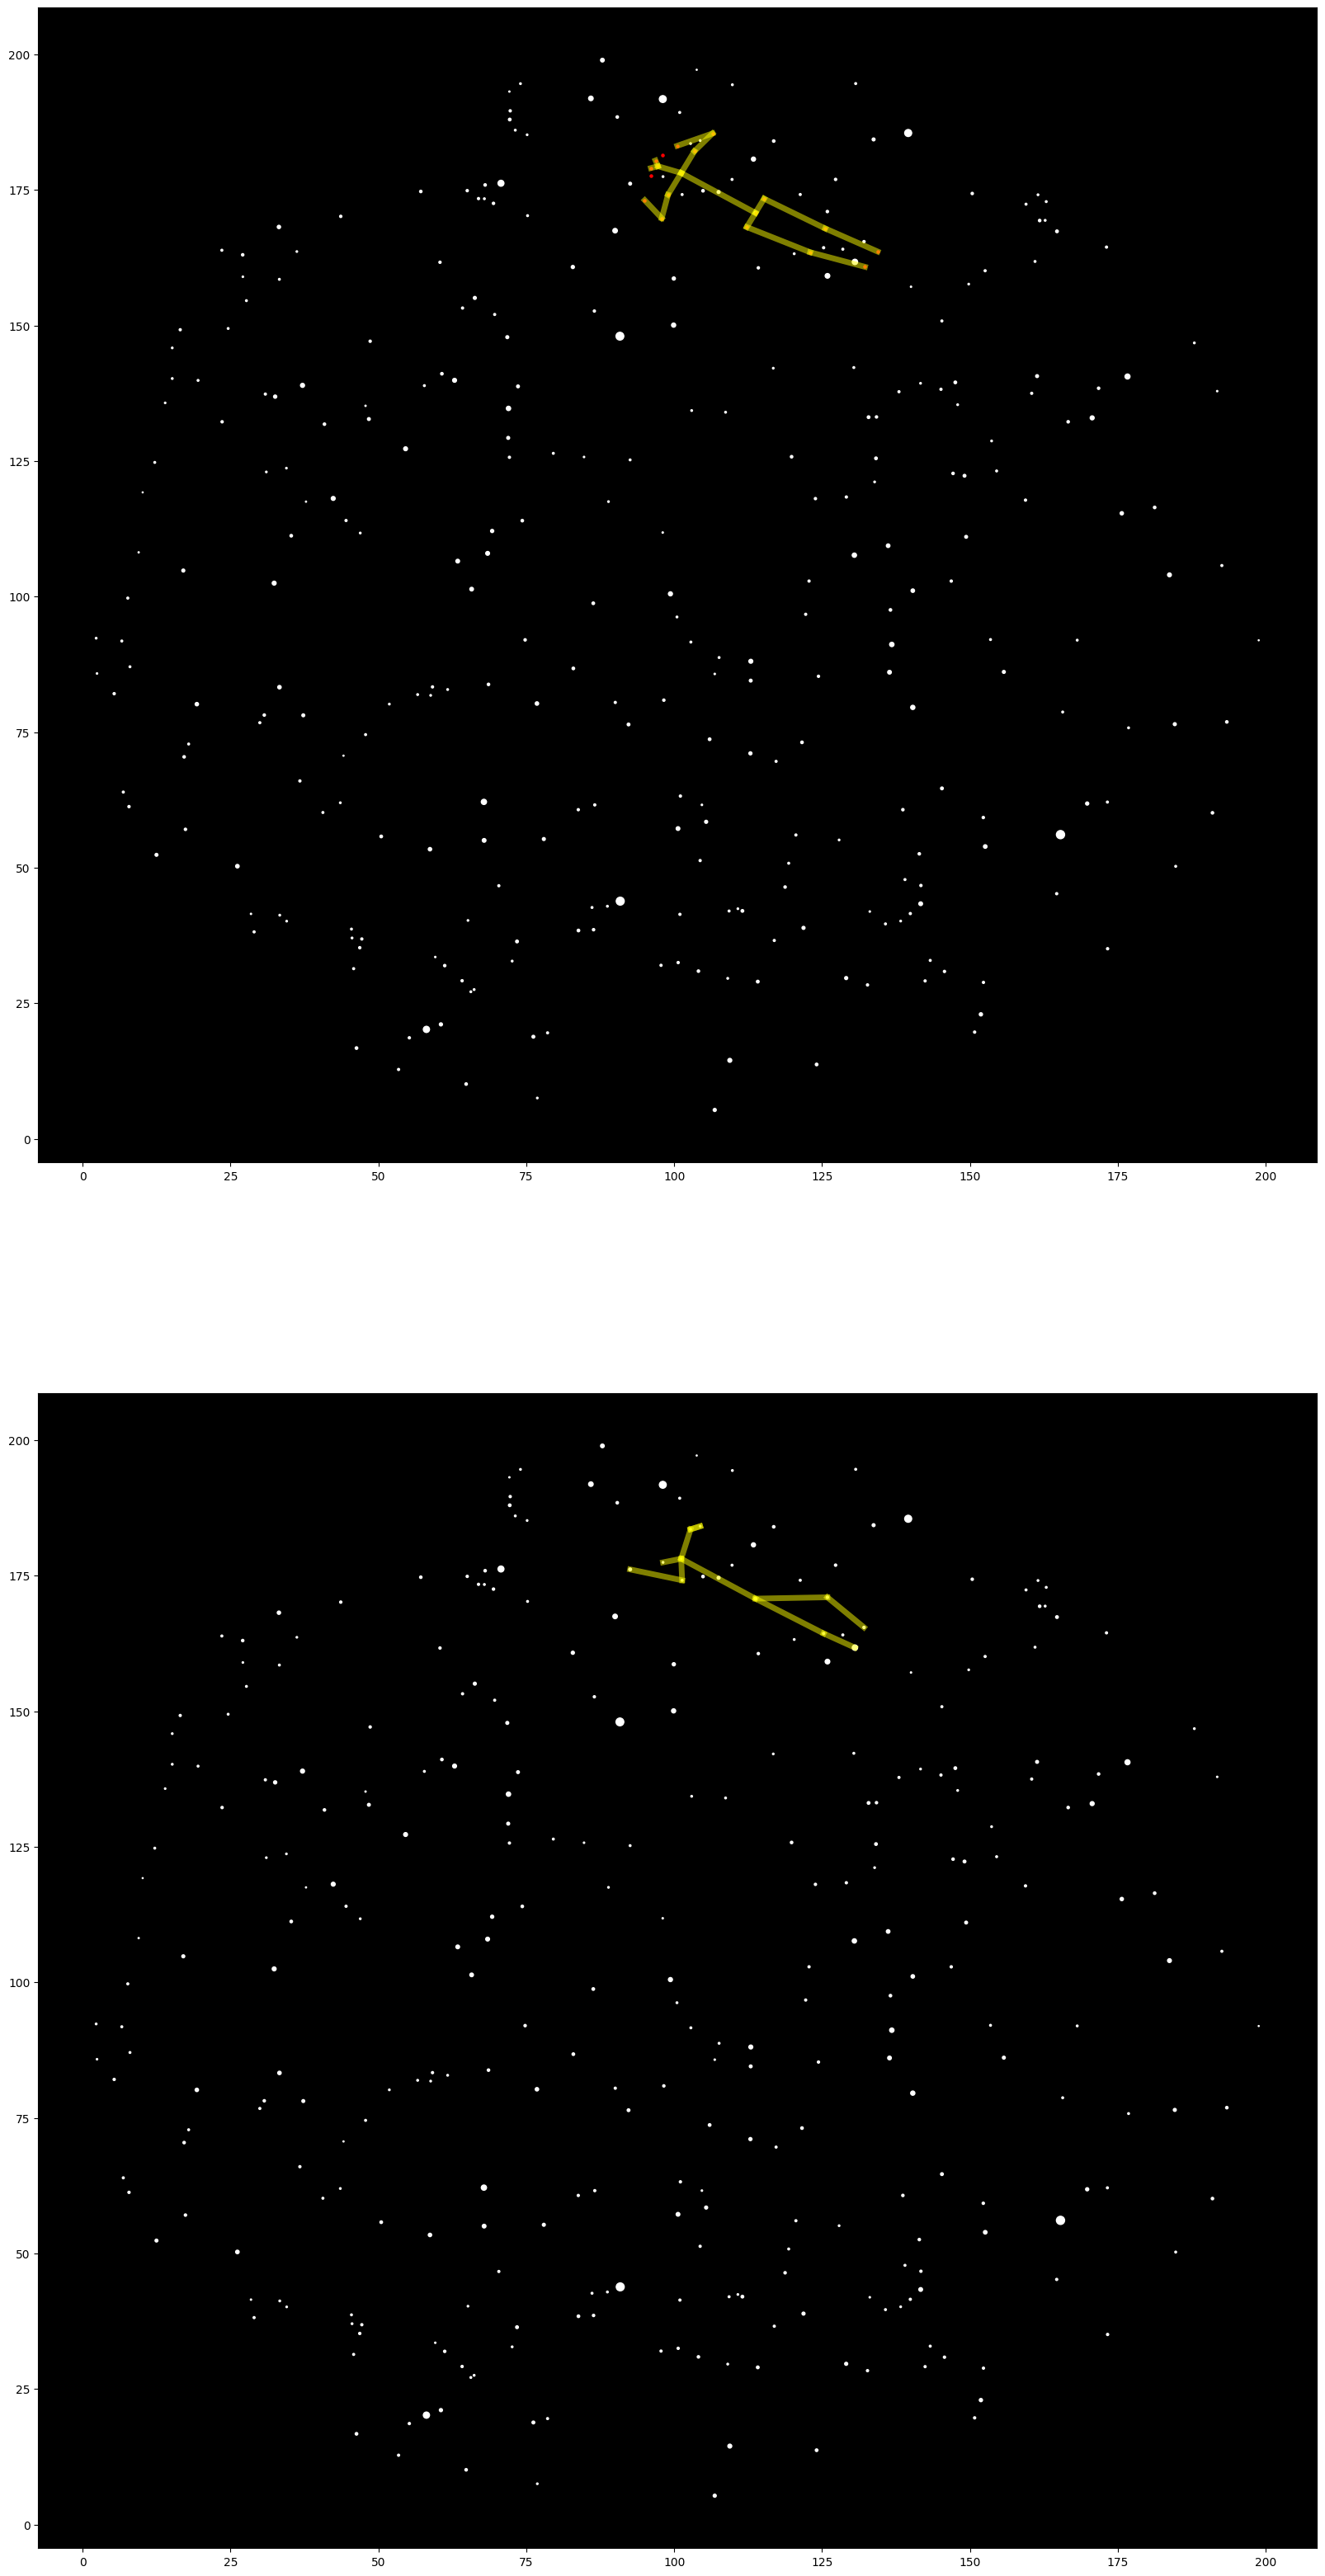

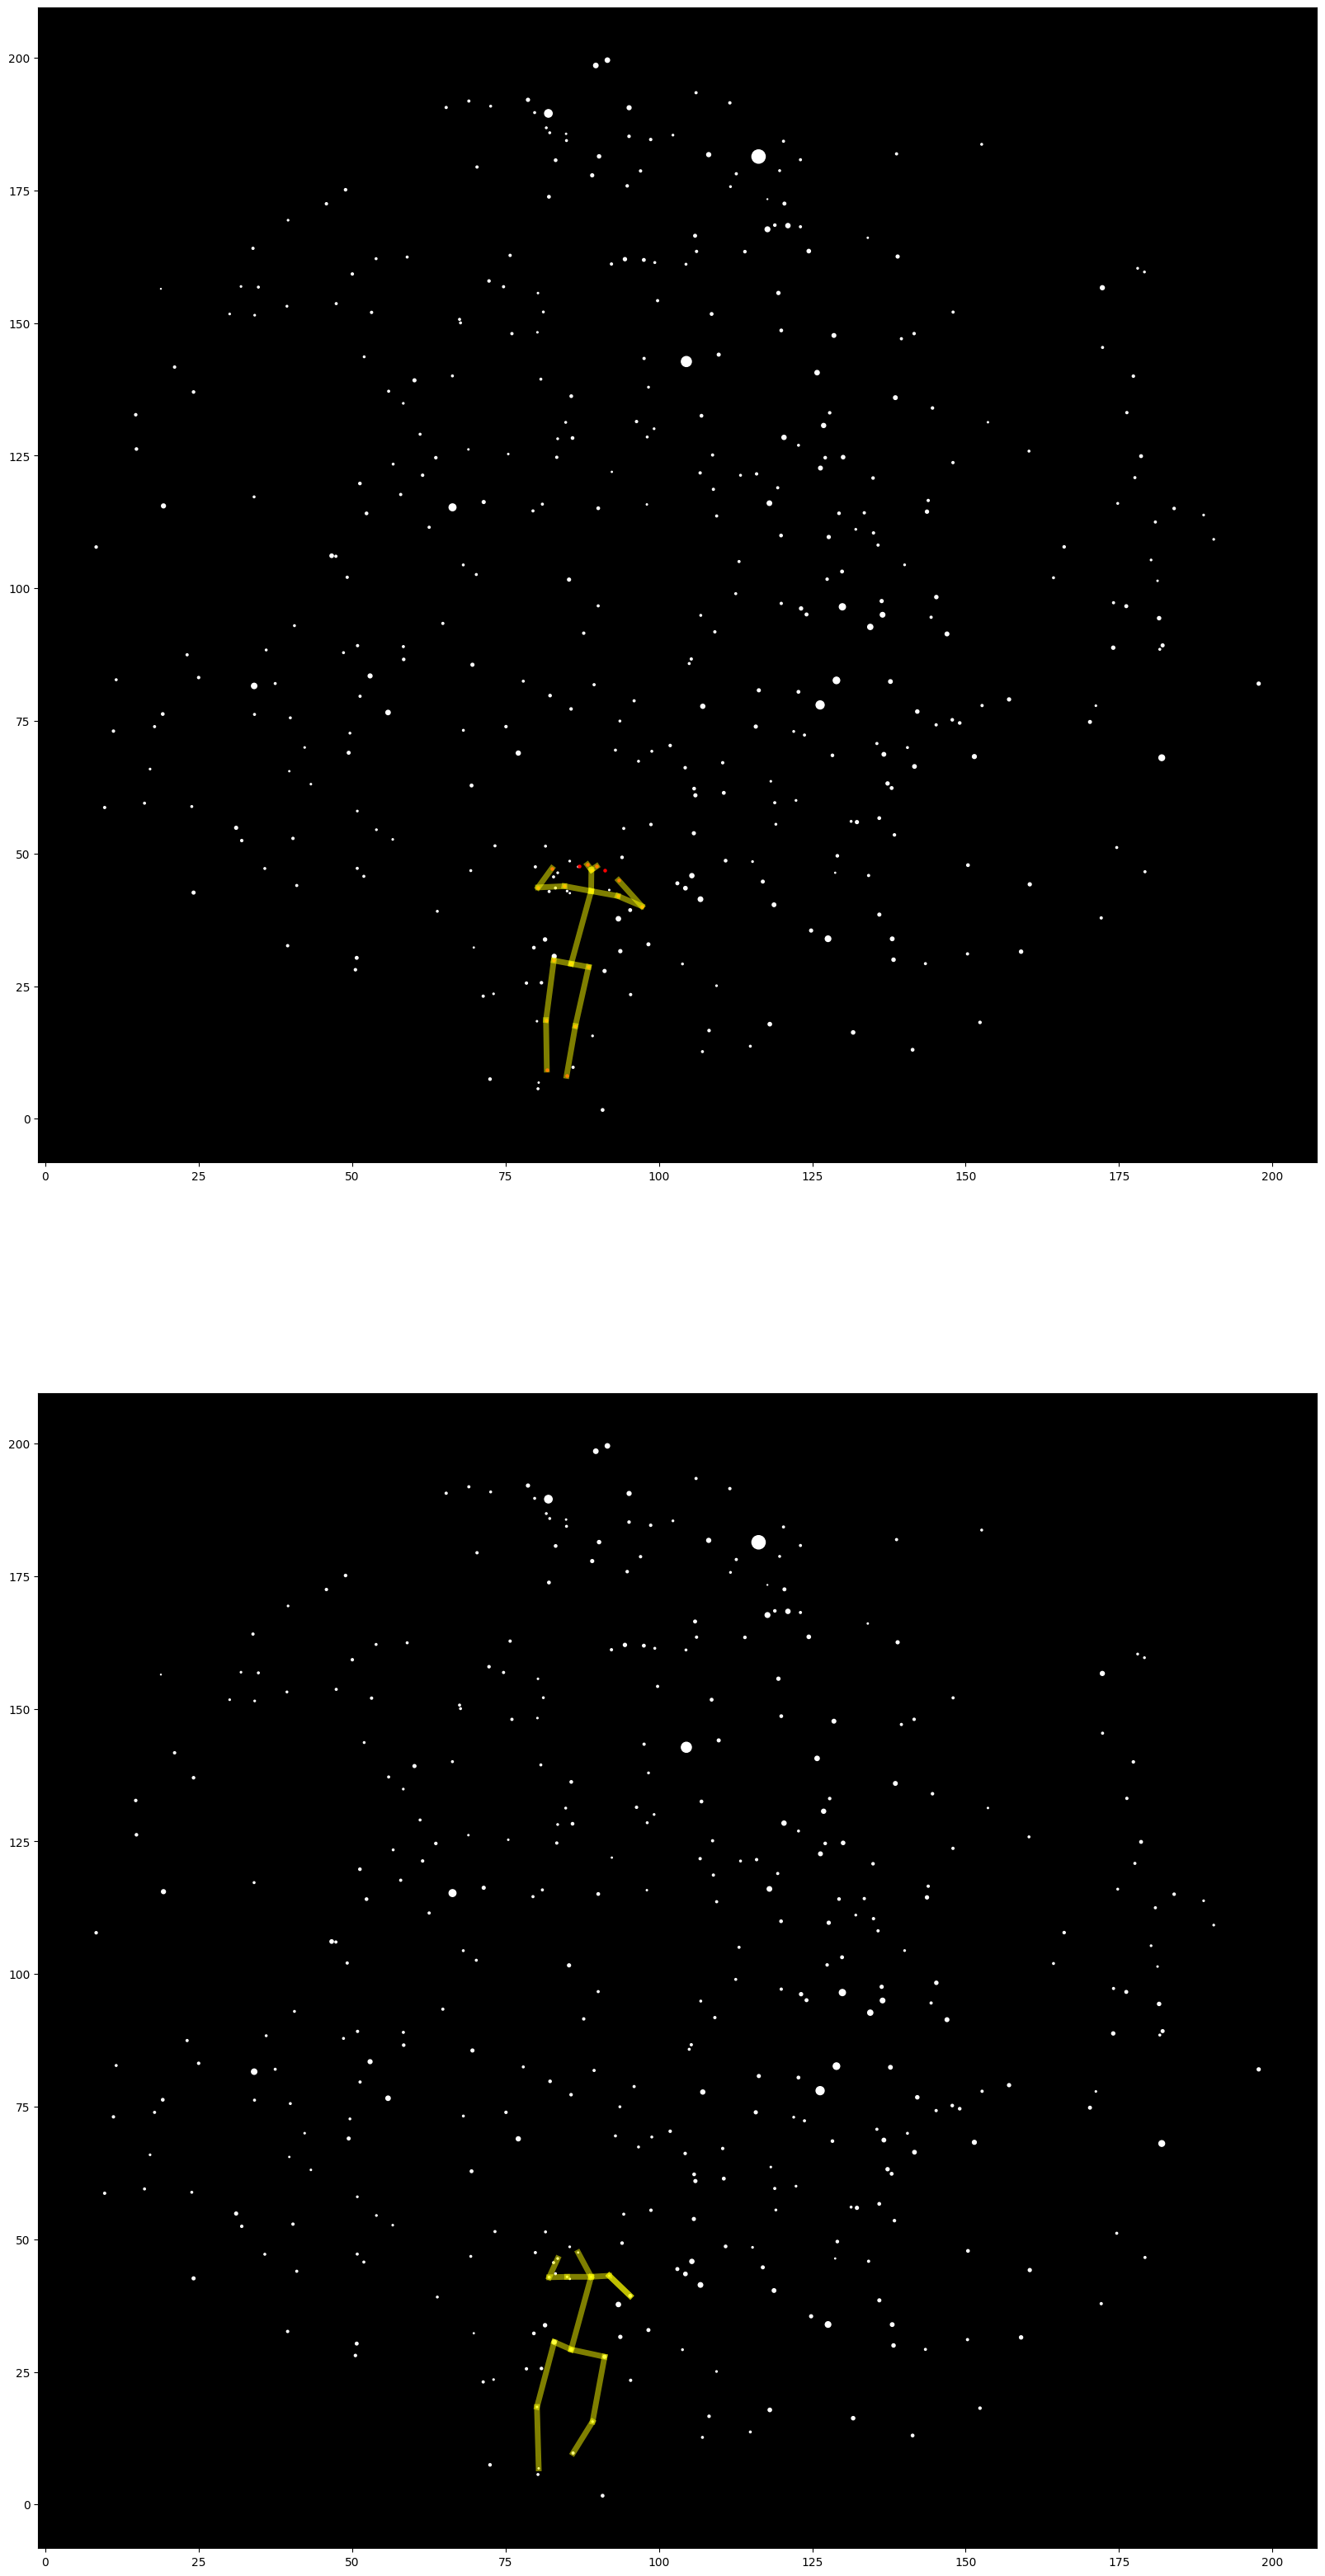

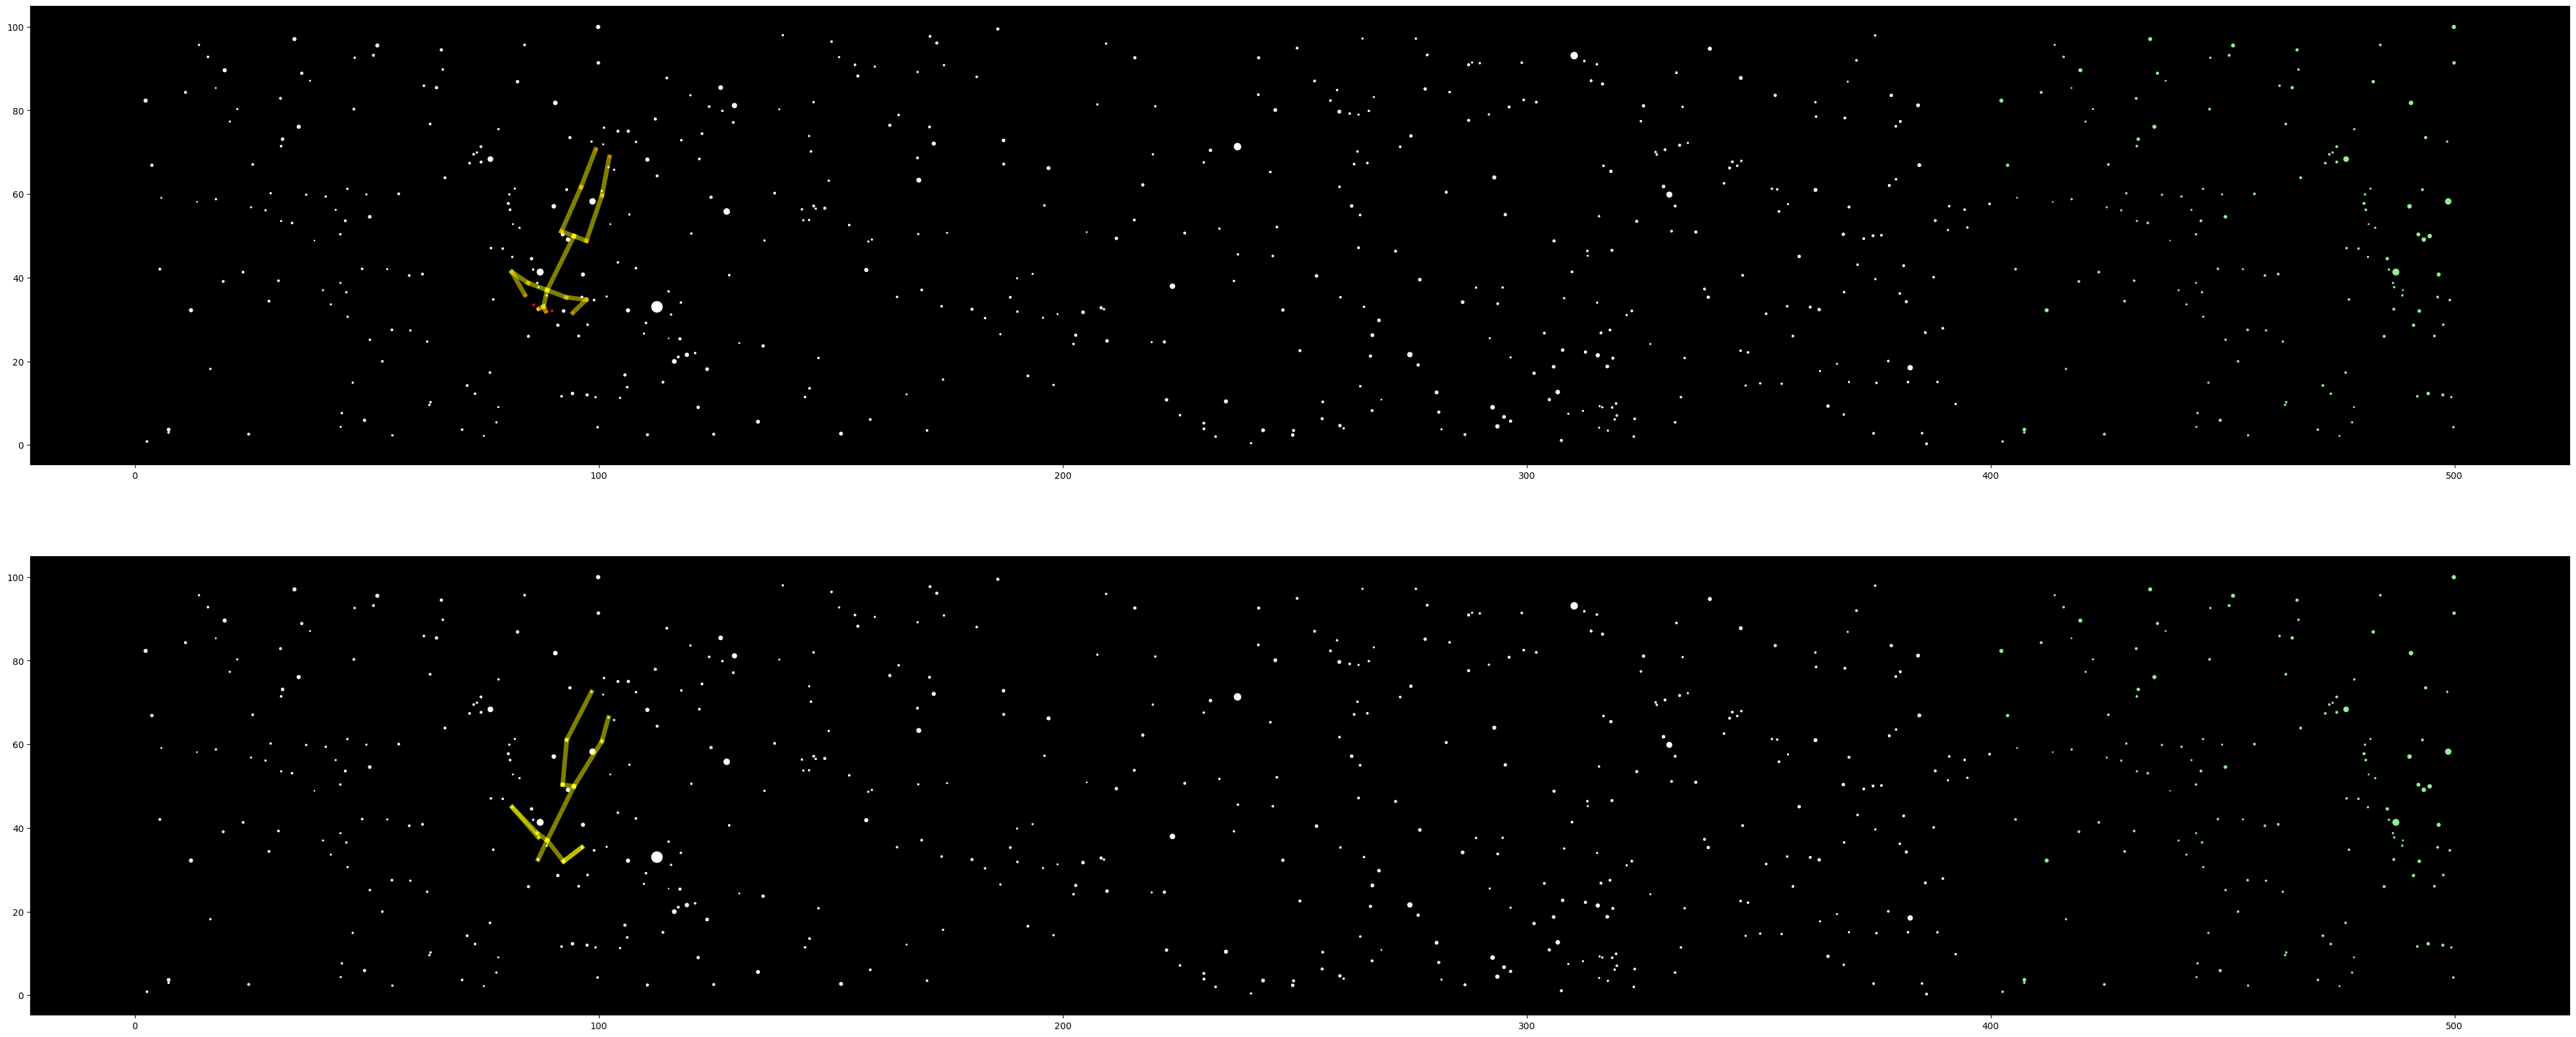

In [214]:
plot_stars([north],point_edge_list)
plot_stars([south],point_edge_list)
plot_stars([equator,ex_equator],point_edge_list)

equator


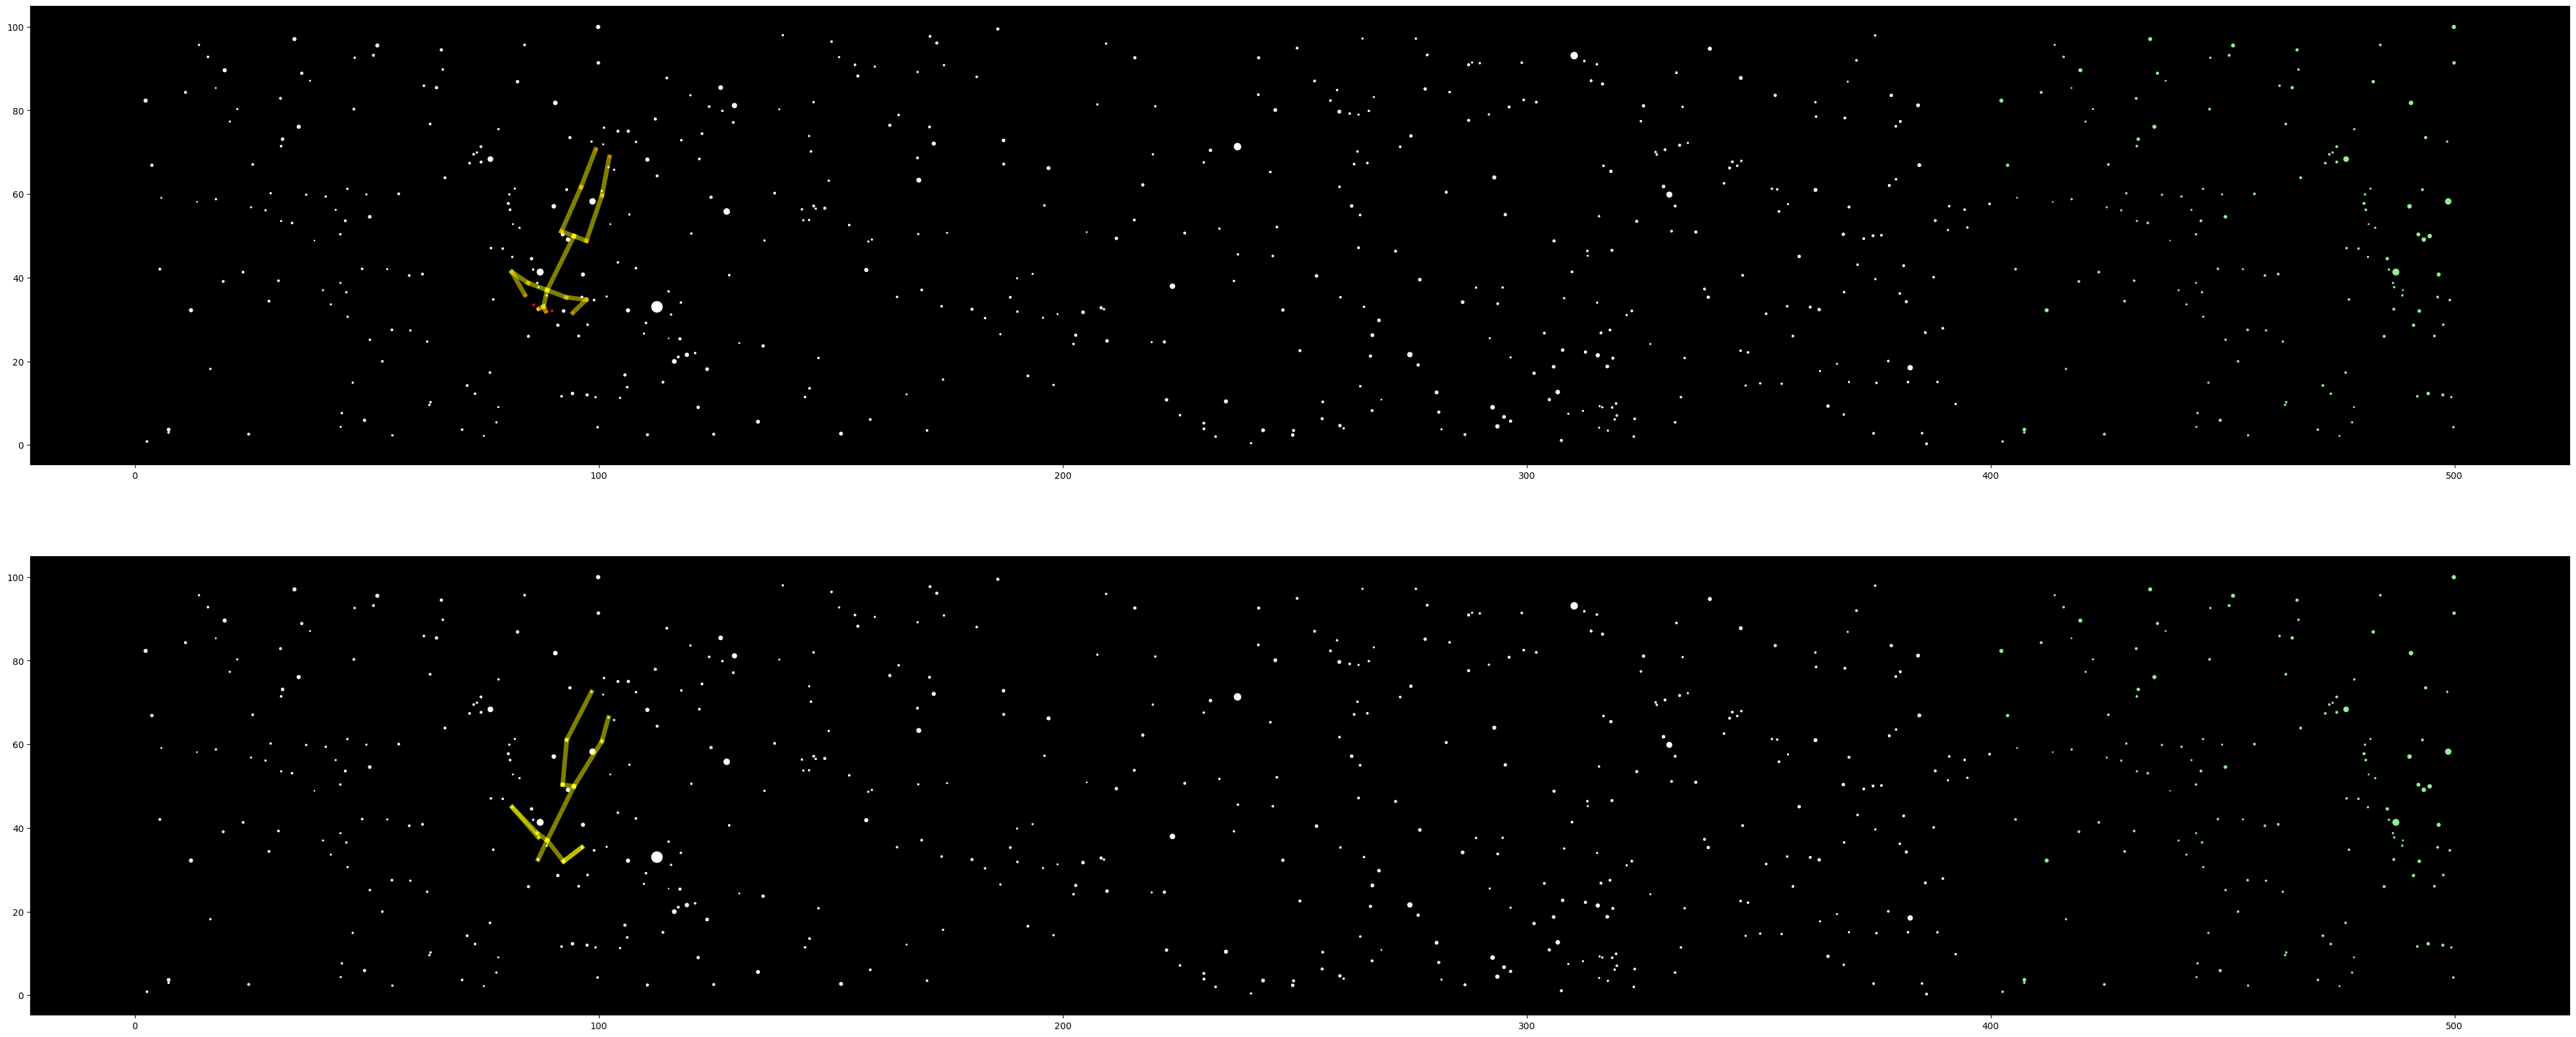

In [212]:
all_locals.print_result(point_edge_list)